# 3F4 Lab on Channel Estimation

## 1) Consider a toy channel

In this lab, we will be concerned with the problem of estimating a channel. A "frequency selective" discrete-time channel, also known as "inter-symbol interference channel" is described as follows,

$$y_k = \sum_{n=0}^L h_n x_{k-n} + n_k, $$

assuming a channel model with time-limited impulse response $h_0,h_1,\ldots,h_L$. The term "frequency selective" focuses on the fact that the spectrum $H(e^{j\theta})$ of the digital channel filter may not be constant or "flat", while the synonymous term "inter-symbol interference" conveys the fact that if you were to just transmit modulated data symbols, e.g., -1s and +1s or multi-level or complex constellations symbols consecutively over the channel, the receiver would get a garbled signal where, rather than having $y_k$ depend only on $x_k$, preceding symbols "interfere" with the current transmitted symbols and hence $y_k$ depends on $x_k, x_{k-1},\ldots,x_{k-L}$. 

You have learned in lectures how real-world continuous channels such as transmission cables or wireless transmission channels can be brought down to such discrete-time models.

For this preliminary exercise, we will pick a known toy channel and then reflect on various ways the channel could be estimated by transmitting test signals and measuring the corresponding received signals.

In [ ]:
import numpy as np
h = np.array([1,-1,-2,1])/np.sqrt(7) 
# feel free to replace these coefficients as you please
# we picked our coefficients so the sum of the coefficients squared is 1

We can view the spectrum of the channel filter in two manners. The first approach evaluates the $z$ transform of $h$ on the half unit circle.

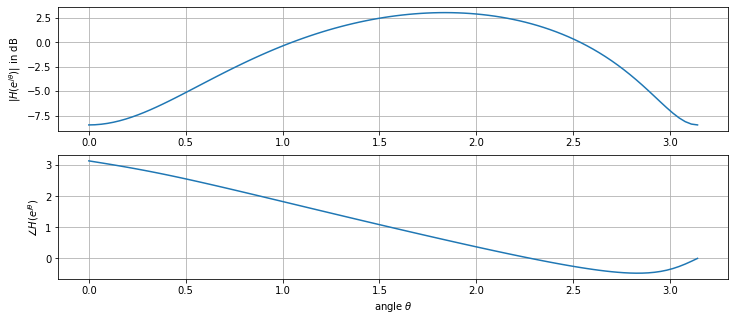

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]
N = 100 # number of points to plot (granularity)
theta = np.linspace(0,np.pi,N) # points on positive half unit circle
Hz = np.polyval(h,np.exp(-1j*theta)) # evaluate H(z) on half unit circle

plt.figure(1)
plt.subplot(211)
plt.plot(theta, 20*np.log10(np.abs(Hz))) # amplitude
plt.ylabel(r'$|H(e^{j\theta})|$'r' in dB')
plt.grid(True)
plt.subplot(212)
plt.plot(theta, np.angle(Hz)) # phase
plt.ylabel(r'$\angle H(e^{j\theta})$')
plt.xlabel(r'angle 'r'$\theta$')
plt.grid(True)


Alternatively, we can view the Discrete Fourier Transform of $h$ extended with a suitable number of zeros to increase granularity

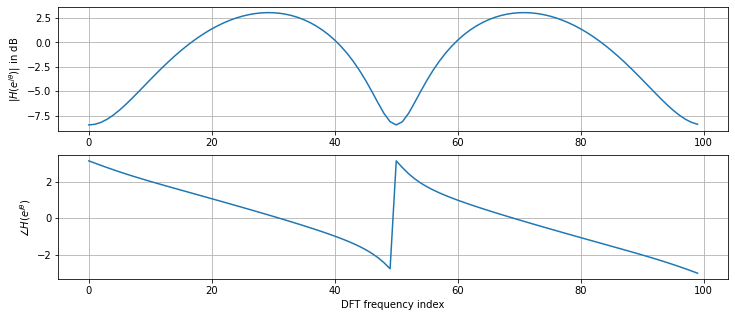

In [ ]:
H = np.fft.fft(np.concatenate((h,np.zeros(N-h.size))))
# concatenate h with a bunch of zeros and take the DFT

plt.figure(1)
plt.subplot(211)
plt.plot(20*np.log10(np.abs(H))) # amplitude
plt.ylabel(r'$|H(e^{j\theta})|$'r' in dB')
plt.grid(True)
plt.subplot(212)
plt.plot(np.angle(H)) # phase
plt.ylabel(r'$\angle H(e^{j\theta})$')
plt.xlabel(r'DFT frequency index')
plt.grid(True)

Note the differences between these two spectrum plots.

## 2) Estimating the toy channel with an impulse

We now forget that we know the toy channel $h$ and focus on how one could estimate the channel by observing input and corresponding output signals. Bear in mind that the real channel operates in continuous time. In the lab, our function generator also operates in continuous time, and our measuring equipment (a picoscope) is a discrete-time device, i.e., an A/D converter followed by some digital signal processing software to display or store digital signals. The discrete time model isn't simply a weakness of our measuring equipment: any communication device nowadays (xDSL modem, Wifi modem, 3G/4G/5G cellular phone) is going to implement the majority of its signal and information processing in discrete-time and hence the discrete-time model of the channel that we considered and that we will measure with a picoscope is realistic and relevant.

However, one reason why it's important to bear in mind the underlying analog nature of the channel is to understand why the "trivial" way to measure a discrete-time impulse response is not going to work. For a discrete-time filter, one could measure the impulse response simply by feeding it with a discrete-time impulse $$\delta_k=\begin{cases} 1\mbox{ for }k=0,\\ 0\mbox{ for }k\neq 0\end{cases}$$ and measuring the corresponding output signal. Since the channel has an additive zero-mean noise component, one could get increasingly good estimates of the channel by repeating the experiment and averaging the corresponding output signals. 

In [ ]:
M = 500 # number of times we average
sigma = .5 # channel noise standard deviation
x = np.array([1,0,0,0,0,0])
y_sum = np.zeros(x.size+h.size-1)
for k in range(M):
  # put the signal through the noisy channel
  y = np.convolve(h,x)+sigma*np.random.randn(x.size+h.size-1)
  y_sum = y_sum + y # add all the output signals together
y_average = y_sum/M # average the output signals
h_estimate = y_average[0:h.size] # cut out the relevant part
print('Actual:   ',h)
print('Estimate: ',h_estimate)

Actual:    [ 0.37796447 -0.37796447 -0.75592895  0.37796447]
Estimate:  [ 0.34543241 -0.44173368 -0.7899809   0.38704317]


However, recall that in the lab our function generation equipment won't give us the freedom to define an arbitrary discrete-time input signal. Even if we had a fully flexible digital function generator, measuring a channel with discrete time impulses is not a good strategy because it results in a very low power signal, giving very noisy measurements that would require a lot of averaging before we got any useful estimates of the channel coefficients ℎ (try to set $\sigma$ to 10 in the script above and you'll see what we mean). At the core of this is the fundamental difference between a discrete-time impulse ("Kronecker delta sequence" $\delta_k$ defined as above) and a continous time impulse ("Dirac impulse function" 𝛿(𝑡)) whose value is undefined/infinite at 𝑡=0 and has finite energy 1. An impulse 𝛿(𝑡) is a thought experiment and cannot be generated in the real world to measure an impulse response. 

In consequence, to measure the channel effectively, we need to feed it with an input signal that has a good deal of power and occupies the whole spectrum relevant for our planned use (otherwise the spectrum of the estimated channel response will be undetermined in frequency bands that were not occupied by our input signal.) Examples of powerful broadband signals are:
* white Gaussian noise, i.e., $X_0,X_1,\ldots$ are independent Gaussian distributed random variables $\mathcal{N}(0,\sigma^2)$.
* a square or triangular waveform. However, bear in mind that if you examine a square or triangular signal from a function generator in detail, it is never perfectly square or triangular simply because no real world equipment can generate infinite bandwidth signals, so it's important to take that into account if you want a good estimate of the channel response $h$.
* any finite length signal whose bandwidth covers the relevant bandwidth of the channel. 

A sinusoid is the exact opposite of a broadband signal and would measure only one point on the frequency axis. However, a frequency sweep or "chirp", i.e., a signal $$x_k=\cos \omega_k k$$ where $\omega_k=\alpha k+\beta$ (linear sweep) or $\omega_k=e^{\alpha k + \beta}$ (exponential or often confusingly called logarithmic sweep because $\log\omega_k$ is linear) is also a good signal to measure a channel with. 


## 3) Estimating the toy channel with a known input signal

We will focus on arbitrary (finite length) input signals, Gaussian noise and chirps in this preparation. In the lab experiment, we will work with whatever is available from the function generator and use the theory we developed for arbitrary input signals to estimate channels, because we currently do not have equipment to generate suitable white noise or chirps. 

First let us consider an arbitray input signal. 

In [71]:
L = 10
# we are picking a random input signal here but feel free to replace it by a deterministic signal of your choosing
x = np.random.randn(L) 
x = x/np.linalg.norm(x)**2
print(x)

[-0.18764582  0.12241149 -0.00269057  0.06247969 -0.1213109  -0.13105174
 -0.14714008 -0.06320805 -0.1510505   0.07812484]


Before we proceed, it's worth checking the spectrum of $x$ to ensure that it doesn't have any notches or severaly attenuated frequency bands. If yours does, re-play the command above or pick a deterministic $x$ with good spectrum characteristics.

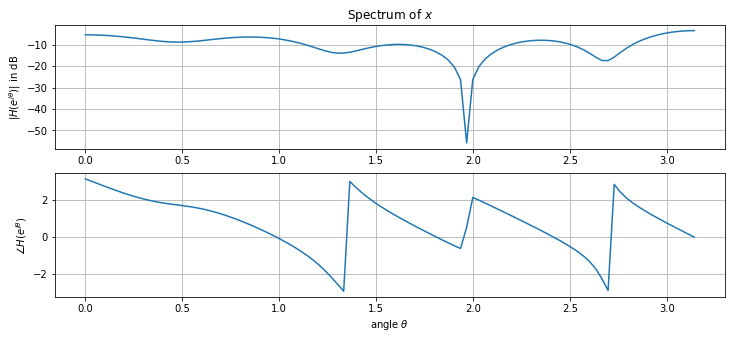

In [72]:
plt.rcParams['figure.figsize'] = [12, 5]
# spectrum of x
Xz = np.polyval(x,np.exp(-1j*theta)) # evaluate X(z) on half unit circle
plt.figure(1)
plt.subplot(211)
plt.plot(theta, 20*np.log10(np.abs(Xz))) # amplitude
plt.ylabel(r'$|H(e^{j\theta})|$'r' in dB')
plt.title(r'Spectrum of 'r'$x$')
plt.grid(True)
plt.subplot(212)
plt.plot(theta, np.angle(Xz)) # phase
plt.ylabel(r'$\angle H(e^{j\theta})$')
plt.xlabel(r'angle 'r'$\theta$')
plt.grid(True)

We can get channel estimates from repeated transmission of $x$ in various ways. The obvious way is to use deconvolution.

In [ ]:
import scipy.signal as sig
sigma = .2
M = 1000
y_sum = np.zeros(x.size+h.size-1)
for k in range(M):
  # put the signal through the noisy channel
  y = np.convolve(h,x)+sigma*np.random.randn(x.size+h.size-1)
  y_sum = y_sum + y # add all the output signals together
y_average = y_sum/M # average the output signals
q,r = sig.deconvolve(y_average,x)
h_estimate = q
print('Actual:   ',h)
print('Estimate: ',h_estimate)

Actual:    [ 0.37796447 -0.37796447 -0.75592895  0.37796447]
Estimate:  [ 0.30607104 -0.23614063 -0.8917459   0.57097912]


Note that we had to pick quite a small noise power $\sigma^2$ for this to give a barely acceptable result (re-try the previous command several times if your result is too far off the mark). The deconvolve function is simply a polynomial division in the $z$ domain and results in a quotient and a remainder. We retain the quotient and discard the remainder. In this simulated experiment, we benefit from perfect synchronisation so we can average first and deconvolve later. If we were to take this approach in the lab working with a signal generator, we would have to synchronise the output signals in some way before averaging them, or deconvolve every measurement then average the estimated responses.

To gain more insight into the result we got, compare the spectrum of $h$ and the estimated response $\hat{h}$.

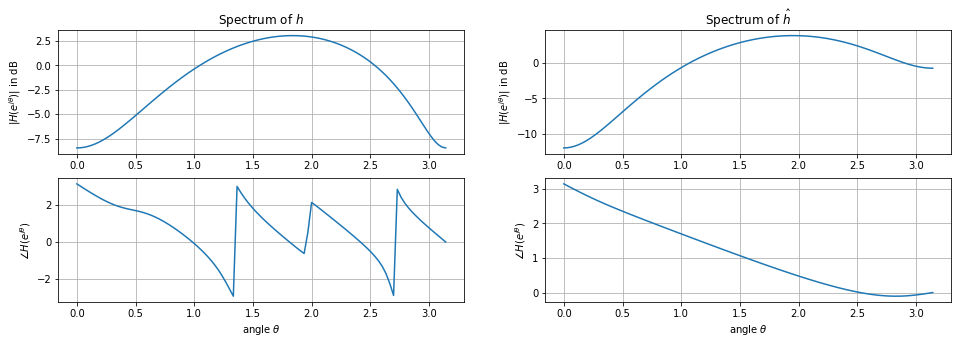

In [73]:
plt.rcParams['figure.figsize'] = [16, 5]
plt.figure(1)
# spectrum of h
plt.subplot(221)
plt.plot(theta, 20*np.log10(np.abs(Hz))) # amplitude
plt.ylabel(r'$|H(e^{j\theta})|$'r' in dB')
plt.title(r'Spectrum of 'r'$h$')
plt.grid(True)
plt.subplot(223)
plt.plot(theta, np.angle(Xz)) # phase
plt.ylabel(r'$\angle H(e^{j\theta})$')
plt.xlabel(r'angle 'r'$\theta$')
plt.grid(True)
# spectrum of h_estimate
Hez = np.polyval(h_estimate,np.exp(-1j*theta)) # evaluate X(z) on half unit circle
plt.subplot(222)
plt.plot(theta, 20*np.log10(np.abs(Hez))) # amplitude
plt.ylabel(r'$|H(e^{j\theta})|$'r' in dB')
plt.title(r'Spectrum of 'r'$\hat{h}$')
plt.grid(True)
plt.subplot(224)
plt.plot(theta, np.angle(Hez)) # phase
plt.ylabel(r'$\angle H(e^{j\theta})$')
plt.xlabel(r'angle 'r'$\theta$')
plt.grid(True)

Deconvolution (polynomial division) is a fragile way of estimating a channel. It's your turn to try out Python commands. You need to find a more robust way of getting a channel estimate. You could try the following:
* estimate the spectrum $\hat{H}$ rather than the impulse response $\hat{h}$. You could either use the DFT or the $z$ transform for this. Either take the DFT of every output and average in the frequency domain, or (more efficient but more reliant on synchronisation) average the outputs in the time domain and take the DFT of the result, then divide by the DFT of $x$. 
* find a filter $g$ whose convolution with $x$ gives something close to a delayed Kronecker delta $\delta_{k-d}$. This is not unlike the devonvolution we tried above, except that when deconvolving we use an IIR filter $$G(z) = \frac{1}{X(z)}$$ which could well be unstable, whereas here you'd be looking for an FIR filter $G(z)$. The delay is necessary to give causal solutions. If you then apply this filter to the output or averaged output, you get \begin{align*}w_k & = \sum_{n=0}^{L_g} g_n y_{k-n} = \sum_{n=0}^{L_g} g_n \left(\sum_{m=0}^{L_h}h_mx_{k-n-m} + n_{k-n}\right)\\ &=\sum_{m=0}^{L_h}h_m\left(\sum_{n=0}^{L_g}g_nx_{k-m-n}\right)+\tilde{n}_k=\sum_{m=0}^{L_h}h_m\delta_{k-m-d}+\tilde{n}_k=h_{k-d}+\tilde{n}_k\end{align*} where $\tilde{n}_k$ is the noise filtered by $g$. 
* for those of you who have taken 3F3, consider what you learned in that module and whether it suggests further ways one could optimally estimate $h$ for a known input signal and measured output signal. 

In [ ]:
# write you own code here to try methods for estimating H(z) using a known input signal

## 4) Estimating the toy channel with input noise

Estimating the channel with input white noise can be done in two ways: 
* if you have full control over the input noise (you know the samples), you can use the cross-spectral density $S_{XY}$ to obtain the exact transfer function of the channel as $$H(z) = \frac{S_{XY}(z)}{S_{XX}(z)}=\frac{S_{XY}(z)}{\sigma^2}.$$ Scipy has a function $\mathtt{scipy.signal.csd}$ to compute the cross-density of a signal.  
* if you have no control of the input signal but you can measure it and the output signal, you can do the above but need to make sure that the input and output signals are correctly synchronised when computing the cross-correlation function / cross density function. 
* if you cannot measure the input signal but can only measure the output signal, you can only estimate the amplitude of the channel response but not its phase, using $$|H(z)|^2 = \frac{S_YY(z)}{\sigma^2}$$ This does not allow us to estimate the impulse response because there are many time sequences of varying length that will yield the same amplitude spectrum. Scipy has a function $\mathtt{scipy.signal.psd}$ to compute the power spectral density of a signal.

In [73]:
# write your own code here to try methods for estimating H(z) using input noise

## 5) Estimating the toy channel with an input chirp

Recall that an infinite length sinusoid convolved with an infinite length sinusoid of a different frequency gives zero: the two signals are "orthogonal". This is easiest seen in the Fourier domain where convolution becomes a multiplication of two Dirac impulse functions shifted to different frequencies, resulting in an all-zero signal. This orthogonality property of sinusoids also holds in the discrete-time domain, but holds only approximately for finite length sinusoids: the integral or sum won't be exactly zero but will be very small compared to the convolution of a finite length sinusoid with a sinusoid of the same frequency. This property is why a chirp (whether linear or logarithmic) convolved with its time-reverse gives something very close to an impulse: a large peak at zero, with very tiny ripples away from zero. If you divide the chirp up into tiny sections of almost constant frequency, each of these sections is orthogonal to all others and "resonnates" only with itself, so in the convolution of the chirp with its time-reverse all of these contribute together to a very significant peak in the middle. Reverting back to our "known signal" approach, this means that when $x$ is a chirp, the signal $g$ that convolved with $x$ gives something close to a delayed Kronecker delta $\delta_{k-d}$ is the time-reversed chirp itself.  

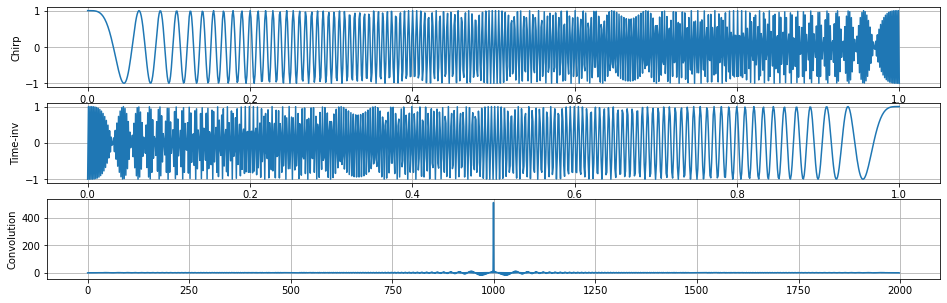

In [82]:
t = np.linspace(0,1,1000) # sample frequency 1 kHz
x = sig.chirp(t, f0=0, f1=499, t1=1, method='linear') # chirp from f=0 to f=fs/2
g = np.flip(x) # time-reversed chirp
plt.rcParams['figure.figsize'] = [16, 5]
plt.figure(1)
# spectrum of h
plt.subplot(311)
plt.plot(t, x) # chirp
plt.ylabel('Chirp')
plt.grid(True)
plt.subplot(312)
plt.plot(t, g) # time-reversed chirp
plt.ylabel('Time-inv')
plt.grid(True)
plt.subplot(313)
plt.plot(np.convolve(x,g))
plt.ylabel('Convolution')
plt.grid(True)

And now to use this insight for channel estimation...

In [93]:
sigma = .5
M = 100
y_sum = np.zeros(x.size+h.size-1)
for k in range(M):
  # put the signal through the noisy channel
  y = np.convolve(h,x)+sigma*np.random.randn(x.size+h.size-1)
  y_sum = y_sum + y # add all the output signals together
y_average = y_sum/M # average the output signals
w = np.convolve(y_average,g)
h_estimate = w[999:1003]/500
print('Actual:   ',h)
print('Estimate: ',h_estimate)


Actual:    [ 0.37796447 -0.37796447 -0.75592895  0.37796447]
Estimate:  [ 0.37219221 -0.38070478 -0.76273902  0.38238336]


Note how robust this method is despite the large value of $\sigma^2$.

Acknoweldgment: this method was discovered and refined by James Cozens during his IIA project GF3 in 2021. He is not the original inventor of the method since it has been known for a long time, but it's not widely known and he re-invented it himself and made it known within the group of students and demonstrators who ran the project. 